# Marker Induction Model (2006)

#### Python Modules and Utility Functions

In [1]:
import numpy as np 
import sys
import math
import time
import random as rnd
import numpy as np
import matplotlib.pyplot as plt
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, IntSlider
import ipywidgets as widgets
import scipy as sp
from scipy import signal


def report_progress(i,iterations,tstart):
	''' Prints to screen the model progress. 

	Parameters
	----------
	i: int 
		Current iteration of the model.

	iterations: int 
		Number of iterations set to run. 

	tstart: float 
		Time of starting the model. 
	'''
    
	progress = ((i+1)*100)/iterations
	t = time.time()
	tpassed = (t-tstart)/60
	time2go = ((tpassed/progress)*100) - tpassed

	sys.stdout.write('\r' + "{0:.3f}".format(progress) + 
                     "% completed.  Time passed: {0:.3f} mins.".format(tpassed) +  
                     "   Expected time left: {0:.3f} mins. ".format(time2go) )
	sys.stdout.flush()

## Model Parameters

In [1]:
RET_DIM_1 = 20
RET_DIM_2 = 20

TEC_DIM_1 = 20
TEC_DIM_2 = 20

FRAME_RATE = 20

INIT_EPHA_CONST_1 = 0.26
INIT_EPHA_CONST_2 = 2.3
INIT_EPHA_CONST_3 = 1.05

INIT_EPHB_CONST = 0.02

INIT_EPHR_CONST_1 = 0.6
INIT_EPHR_CONST_2 = 0.5

NUM_INIT_SYNS = 10
INIT_MAX_SYN = 0.0001

COMPL_CONST = 0.0504					# kappa
WEIGHT_UPDATE_RATE = 0.1				# gamma

EPHR_UPDATE_CONST_1 = 0.05				# alpha
EPHR_UPDATE_CONST_2 = 0.01				# beta

dt = 1

## Initialisation

#### Eph Initialisation

Eph-A density across the nasal-temporal axis of the retina is intialised to follow the equation $y=a e^{bx} + c$ for parameters $a$,$b$,$c$. 

Eph-B density across the doral-ventral axis of the retina initialised to follow the equation $y=\frac{x}{N_2}$ for $N_2$ the number of cells in the dorsal-ventral axis of the retinal sheet.  

In [3]:
def init_EphA():
	""" Creates a nasal-temporal EphA concentration gradient in the retina. 
		See Reber et al. 2004.

		Returns
		-------
		EphA: 2D Array
			EphA concentration in each cell of the retina. 
	"""
	a = INIT_EPHA_CONST_1
	b = INIT_EPHA_CONST_2
	c = INIT_EPHA_CONST_3

	EphA = np.array([[ a*np.exp(b*((i)/(RET_DIM_1-1))) + c 
		for j in range(RET_DIM_2)] for i in range(RET_DIM_1)])

	return EphA


def init_EphB():
	""" Creates a dorsal-ventral EphB concentration gradient in the retina. 
		
		Returns
		-------
		EphB: 2D Array
			EphA concentration in each cell of the retina. 
	"""
	EphB = np.array([[ ((j))/(RET_DIM_2-1) 
		for j in range(RET_DIM_2)] for i in range(RET_DIM_1)])

	return EphB

#### ephrin Initialisation

ephrin-A and B densities across the posterior-anterior and lateral-medial axis respectively, are initialised to fit equations of the form $y=ax + c\Pi$ for parameters $a$ and $b$, where $\Pi \sim U[0,1]$.

In [4]:
def init_ephrA():
	"""Creates a posterior-anterior ephrin-A concentration gradient in the tectum. 

		Returns
		-------
		ephrA: 2D Array
			ephrin-B concentration in each cell of the tectum. 
	"""

	a = INIT_EPHR_CONST_1
	b = INIT_EPHR_CONST_2
	ephrA = np.array([[ a*(1- i/(TEC_DIM_1-1)) + b*np.random.uniform(0,1) 
		for j in range(TEC_DIM_2)] for i in range(TEC_DIM_1)])

	return ephrA


def init_ephrB():
	"""" Creates a lateral-medial ephrin-B concentration gradient in the tectum.
		See Tom Bland 2017. 

		Returns
		-------
		ephrB: 2D Array
			ephrin-B concentration in each cell of the tectum. 
	"""

	a = INIT_EPHR_CONST_1
	b = INIT_EPHR_CONST_2
	ephrB = np.array([[ a*(j/(TEC_DIM_2-1)) + b*np.random.uniform(0,1) 
		for j in range(TEC_DIM_2)] for i in range(TEC_DIM_1)])

	return ephrB

#### Initialising synaptic weights

In [5]:
def init_syns():
	""" Creates randomly weighted connections between retina and tectum.
		
		Returns
		-------
		syn_weights: 4D Array
			4D Array of uniformly random values.

	"""
	syn_weights = np.random.uniform(0,INIT_MAX_SYN,
		(RET_DIM_1,RET_DIM_2,TEC_DIM_1,TEC_DIM_2))
	return syn_weights

#### Collating initialised components

In [6]:
def initialise():
	"""" Initialises all components of Marker Induction Model (2006). 

	Returns
	-------
	EphA_conc: 2D Array
		EphA concentration in each retinal cell with nasal-temporal gradient. 

	EphB_conc: 2D Array
		EphB concentration in each retinal cell with dorsal-ventral gradient. 

	ephrA_conc: 2D Array
		ephrin-A concentration in each tectal cell with posterior-anterior gradient.

	ephrB_conc: 2D Array
		ephrin-B concentration in each tectal cell with lateral-medial gradient.

	induced_EphA: 2D Array
		Zero array the size of tectal sheet.

	induced_EphB: 2D Array
		Zero array the size of tectal sheet. 

	syn_weights: 4D Array
		Uniform random synaptic weights between each retinal and tectal cell. 

	"""
	EphA_conc = init_EphA()
	EphB_conc = init_EphB()

	ephrA_conc = init_ephrA()
	ephrB_conc = init_ephrB()

	induced_EphA = np.zeros((TEC_DIM_1,TEC_DIM_2))
	induced_EphB = np.zeros((TEC_DIM_1,TEC_DIM_2))

	syn_weights = init_syns()

	params = (EphA_conc,EphB_conc,ephrA_conc,ephrB_conc,
		induced_EphA,induced_EphB,syn_weights)

	return params


## Model Procedure

#### 1. Induce Eph into Tectum

In [7]:
def induce_Eph(syn_weights,Eph_conc):
	""" Computes weighted density of EphA/B in retina cells ennervating each tectal cell.

	Parameters
	----------
	syn_weights: 4D Array
		Synaptic weights between each cell in retina and tectum.

	Eph_conc: 2D Array
		EphA or EphB concentration in each retinal cell. 


	Returns
	--------
	induced_Eph: 2D Array
		Induced EphA/B concentration in each tectal cell. 

	"""

	induced_Eph = np.zeros((TEC_DIM_1,TEC_DIM_2))

	reshaped_syns = np.reshape(syn_weights,(RET_DIM_1*RET_DIM_2,TEC_DIM_1*TEC_DIM_2))
	reshaped_Eph = np.reshape(Eph_conc,(RET_DIM_1*RET_DIM_2,1))
	nume = np.sum(np.multiply(reshaped_syns,reshaped_Eph),axis=0)
	denom = np.sum(reshaped_syns,axis=0)
	reshaped_ind = np.divide(nume,denom)
	induced_Eph = np.reshape(reshaped_ind,(TEC_DIM_1,TEC_DIM_2)) 
    
	return induced_Eph

#### 2. Update ephrin concentrations

In [8]:
def update_ephrs(ind_EphA,ind_EphB,ephrA_conc,ephrB_conc):
	""" Updates tectal ephrin-A and ephrin-B concentrations from
	induced EphA/B concentrations. 

	Note: Laplacian estimated by mean ephrin-A concentration among neighbours.


	Parameters
	----------
	ind_EphA: 2D Array
		Induced EphA concentration in each tectal cell.

	ind_EphB: 2D Array
		Induced EphB concentration in each tectal cell.

	ephrA_conc: 2D Array
		ephrin-A concentration in each tectal cell. 

	ephrB_conc: 2D Array
		ephrin-B concentration in each tectal cell. 


	Returns
	-------
	ephrA_conc: 2D Array
		New ephrin-A concentrations in each tectal cell. 

	ephrB_conc: 2D Array
		New ephrin-B concentrations in each tectal cell. 

	"""
    
	alpha = EPHR_UPDATE_CONST_1
	beta = EPHR_UPDATE_CONST_2

	mean_filter = np.array([[0,1,0],[1,0,1],[0,1,0]])
	bool_array = ephrA_conc.astype(bool)
	num_neighbours = sp.signal.convolve2d(bool_array, mean_filter, 
		mode='same', boundary='fill', fillvalue=0)

	sum_neighboursA = sp.signal.convolve2d(ephrA_conc, mean_filter, 
		mode='same', boundary='fill', fillvalue=0)
	laplA = np.divide(sum_neighboursA,num_neighbours)

	sum_neighboursB = sp.signal.convolve2d(ephrB_conc, mean_filter, 
		mode='same', boundary='fill', fillvalue=0)
	laplB = np.divide(sum_neighboursB,num_neighbours)

	ephrA_change = alpha*(1-ind_EphA*ephrA_conc) + beta*(laplA-ephrA_conc)
	ephrB_change = alpha*(ind_EphB-ephrB_conc) + beta*(laplB - ephrB_conc)

	ephrA_conc = np.add(ephrA_conc,ephrA_change*dt)
	ephrB_conc = np.add(ephrB_conc,ephrB_change*dt)

	return (ephrA_conc,ephrB_conc)

#### Update synaptic weights

In [9]:
def update_weights(syn_weights,EphA_conc,EphB_conc,ephrA_conc,ephrB_conc):
	""" Updates synaptic weights using similarity between Eph and ephrin
	concentrations.

	Parameters
	----------
	syn_weights: 4D Array
		Synaptic weights between each retinal and tectum cell.  

	EphA_conc: 2D Array
		EphA concentration in each retinal cell.

	EphB_conc: 2D Array
		EphB concentration in each retinal cell. 

	ephrA_conc: 2D Array
		ephrin-A concentration in each tectal cell. 

	ephrB_conc: 2D Array
		ephrin-B concentration in each tectal cell. 


	Returns
	-------

	syn_weights: 4D Array
		Updated synaptic weights between each retina and tectum cell. 
	"""

	gam = WEIGHT_UPDATE_RATE

	term1 = np.multiply.outer(EphA_conc,ephrA_conc)
	term1 -= 1
	term1 = np.square(term1)

	term2 = np.subtract.outer(EphB_conc,ephrB_conc)
	term2 = np.square(term2)

	dist = np.add(term1,term2)
	compl = np.exp(-dist/(2*COMPL_CONST**2))

	numer = syn_weights + gam*compl*dt
	denom = np.sum(numer,axis=(2,3))

	# reshape for vectorisation
	reshape_nume = np.reshape(numer,(RET_DIM_1*RET_DIM_2,TEC_DIM_1*TEC_DIM_2))
	reshape_denom = np.reshape(denom,(RET_DIM_1*RET_DIM_2,1))
	reshaped_weights = np.divide(reshape_nume,reshape_denom)
	
	syn_weights = np.reshape(reshaped_weights,(RET_DIM_1,RET_DIM_2,TEC_DIM_1,TEC_DIM_2))

	return syn_weights

## Calculating Receptive Fields

In [10]:
def calc_rf_centre(k,l,syn_weights):
	""" Calculates the coordinates of the receptive field 
	for a particular tectal cell. 
	i.e. the weighted mean position of retinal cells ennervating a
	particular tectal cell.  

	Parameters
	----------
	k: int
		Lateral-medial coordinate of tectal cell. 

	l: int
		Posterior-anterior coordinate of tectal cell.

	syn_weights: 4D Array
		Synaptic weights between each retina and tectum cell. 


	Returns
	-------
	x: int
		Dorsal-ventral coordinate for receptive field centre.

	y: int
		Nasal-temporal coordinate for recpetive field centre. 

	"""

	if(np.any(np.sum(syn_weights[:,:,k,l]))):
		x = np.sum(np.multiply(syn_weights[:,:,k,l],np.matrix([i for i in range(0,RET_DIM_1)]).T))
		x = x/np.sum(syn_weights[:,:,k,l])

		y = np.sum(np.multiply(syn_weights[:,:,k,l],np.matrix([j for j in range(0,RET_DIM_2)])))
		y = y/np.sum(syn_weights[:,:,k,l])
	else:
		x = 0
		y = 0

	field_cent = (x,y)

	return field_cent

## Running the Simulation

In [11]:
def run(iterations):
	""" Runs simulation of Marker Model and saves data to NPY files.

	A simulation cycle consists of:
	1) Updating synaptic weights
	2) Inducing EphA and EphB into tectum
	3) Updating tectal labels. 

	Parameters
	----------
	iterations: int
		Number of iterations to iterate simulation cycle. 

	Returns
	-------
	iter_weights: 5D Array
		Synaptic weights at various iterations of the simulation.

	rec_fields: 4D Array
		Receptive field coordinates of each tectal neuron at various
		iterations of the simulation.  
	"""

	print("Running Marker Induction Model (2006)...")
	tstart = time.time()
	(EphA_conc,EphB_conc,ephrA_conc,ephrB_conc,ind_EphA,
	ind_EphB,syn_weights) = initialise()

	rec_fields = np.zeros((math.floor(iterations/FRAME_RATE)+1,
		TEC_DIM_1,TEC_DIM_2,2))

	iter_weights = np.zeros((math.floor(iterations/FRAME_RATE)+1,
		RET_DIM_1,RET_DIM_2,TEC_DIM_1,TEC_DIM_2))

	for i in range(iterations):
		syn_weights = update_weights(syn_weights,EphA_conc,
			EphB_conc,ephrA_conc,ephrB_conc)

		ind_EphA = induce_Eph(syn_weights,EphA_conc)
		ind_EphB = induce_Eph(syn_weights,EphB_conc)

		(ephrA_conc,ephrB_conc) = update_ephrs(ind_EphA,
			ind_EphB,ephrA_conc,ephrB_conc)

		if(i%FRAME_RATE == 0):
			index = math.floor(i/FRAME_RATE)
			iter_weights[index,:,:,:,:] = syn_weights
			for k in range(TEC_DIM_1):
				for l in range(TEC_DIM_2):
					(x,y) = calc_rf_centre(k,l,syn_weights)
					rec_fields[index,k,l,0] = x
					rec_fields[index,k,l,1] = y

		report_progress(i,iterations,tstart)
		
	iter_weights[iter_weights<0.001] = 0
	return (iter_weights,rec_fields)

In [16]:
(iter_weights,rec_fields) = run(2000)

Running Marker Induction Model (2006)...
100.000% completed.  Time passed: 0.240 mins.   Expected time left: -0.000 mins. 

## Visualising the Retinotopic Map

In [22]:
def plot_iteration(iteration):
	rf = rec_fields[iteration,:,:,:]

	for k in range(TEC_DIM_1):
		x1 = []
		y1 = []
		for l in range(TEC_DIM_2):
			if(rf[k,l,0]!=0 and rf[k,l,1] != 0):
				x1.append(rf[k,l,0])
				y1.append(rf[k,l,1])

		plt.plot(x1,y1,c='k')

	for l in range(TEC_DIM_2):
		x2 = []
		y2 = []
		for k in range(TEC_DIM_1):
			if(rf[k,l,0]!=0 and rf[k,l,1] != 0):
				x2.append(rf[k,l,0])
				y2.append(rf[k,l,1])

		plt.plot(x2,y2,c='k')
	plt.xlim(0,RET_DIM_1)
	plt.ylim(0,RET_DIM_2)
	plt.show()

    
def update_lattice(val):
	val = int(val/FRAME_RATE)
	plt.axes().set_aspect('equal')
	plt.xlabel('Nasal-Temporal Position')
	plt.ylabel('Dorsal-Vental Position')
	plot_iteration(val)

    
def plot_lattice(rfs):
    global rec_fields
    rec_fields = rfs

    fig = plt.figure()
    plt.xlim(0,RET_DIM_1)
    plt.ylim(0,RET_DIM_2)
    update_lattice(0)

    interact(update_lattice,val=IntSlider(min=0,
    max=(len(rec_fields[:,0,0,0])-1)*FRAME_RATE-1,
    step=1,description="Iteration: "))


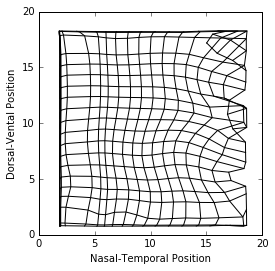

In [23]:
plot_lattice(rec_fields)